In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m

In [91]:
combined_slice = np.zeros((20,20,20))
# for i in [29,39, 59,70]:
for i in [39]:
    first_half = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/HPparslice_3D_res3_test1.dat'%i).reshape((11,20,20))
    second_half = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/%s/HPparslice_3D_res3_test2.dat'%i).reshape((10,20,20))
    combined_slice[0:10] = first_half[0:10]
    combined_slice[10:] = second_half
    output_filename = './Specifically Evolved HP mechanisms/Every Circuit/%s/HPparslice_3D_res3_noHPtest.dat'%i
    with open(output_filename, 'w') as f:
    # Iterate through the first dimension (each 2D slice)
        for j in range(combined_slice.shape[0]):
            # Save the current 2D slice to the file
            # Use a delimiter (e.g., space) to separate elements within a row
            # Use newline='\n' to ensure a newline after each row of the 2D slice
            np.savetxt(f, combined_slice[j], fmt='%d', delimiter=' ', newline='\n')
            
            # Add an extra newline to separate the 2D slices in the .dat file
            if j < combined_slice.shape[0] - 1: # Avoid adding an extra newline after the last slice
                f.write('\n')

format a figure for visualizing 3D performance and then compare the noHPtest condition to the HPtest condition

In [92]:
#i just wonder whether the axes on these are right...
# combined_slice = combined_slice.swapaxes(0,2)
combined_slice_flattened = combined_slice.flatten()

In [94]:
rainbow = m.colormaps['RdYlGn']
colors = rainbow(np.linspace(0,1,28))

In [164]:
pt_list = np.arange(0,1,.05)
pt_gridx,pt_gridy,pt_gridz = np.meshgrid(pt_list,pt_list,pt_list,indexing='xy')
pts = np.array(list(zip(pt_gridy.ravel(),pt_gridx.ravel(),pt_gridz.ravel())))

[[0.  0.  0. ]
 [0.  0.  0.5]
 [0.  0.5 0. ]
 [0.  0.5 0.5]
 [0.5 0.  0. ]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]
 [0.5 0.5 0.5]]


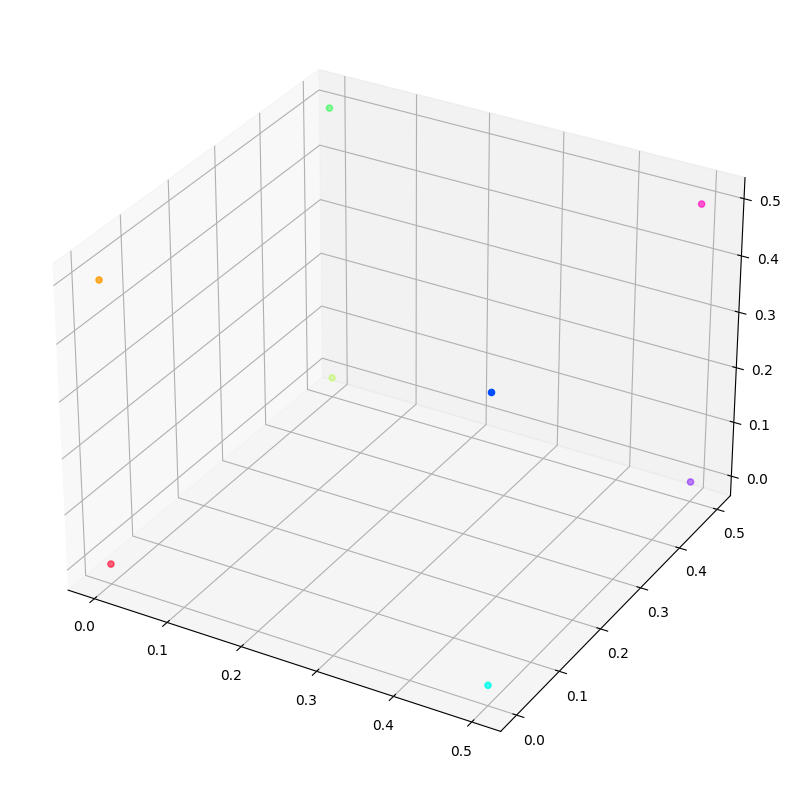

In [89]:
rainbow = m.colormaps['gist_rainbow']
colors = rainbow(np.linspace(0,1,8))
data = np.array([[[0,1],[2,3]],[[4,5],[6,7]]])
data_flatten = data.flatten()
pt_listtest = np.arange(0,1,.5)
pt_gridxtest,pt_gridytest,pt_gridztest = np.meshgrid(pt_listtest,pt_listtest,pt_listtest,indexing='xy')
ptstest = np.array(list(zip(pt_gridytest.ravel(),pt_gridxtest.ravel(),pt_gridztest.ravel())))
print(ptstest)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection='3d')
ax.scatter(ptstest[:,0],ptstest[:,1],ptstest[:,2],color = colors[data_flatten])

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection='3d')
ax.set_box_aspect(None, zoom=0.85)
ax.grid(False)
for i in range(len(pts)):
    ax.scatter(pts[i,0],pts[i,1],pts[i,2],color=colors[combined_slice_flattened[i].astype(int)],s=1,alpha=(combined_slice_flattened[i]>2).astype(int))
ax.set_xlabel(r'$B_{LP}$')
ax.set_ylabel(r'$B_{PY}$')
ax.set_zlabel(r'$B_{PD}$')
ax.tick_params(pad=-1)
ax.xaxis.set_tick_params(pad=-2.5)
ax.set_xticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax.set_yticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax.set_zticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
plt.savefig('../Figures/HPPerf3Dtest.eps')

Format an equivalent/comparable figure for visualizing the HP-agnostic average distribution

In [130]:
#First, a funciton to eliminate the unstable averages and their corresponding pyloric points from the dataset
#alternatively, could keep track and plot in a different color

#right now, unidirectional
def scrub_instability(pyloric,avgs):
    stability = np.zeros_like(pyloric)
    #implicitly never including the last row/column/stack in each dimension
    for i in range(len(stability)-1):
        for j in range(len(stability[0])-1):
            for k in range(len(stability[0,0])-1):
                # stability in the par1 dimension
                if avgs[i,j,k,0] > avgs[i+1,j,k,0]:
                    #par2 dimension
                    if avgs[i,j,k,1] > avgs[i,j+1,k,1]:
                        #par3 dimension
                        if avgs[i,j,k,2] > avgs[i,j,k+1,2]:
                            stability[i,j,k] = 1
    pyloric = pyloric[np.where(stability==1)]
    avgs = avgs[np.where(stability==1)]
    return pyloric,avgs

In [ ]:
#Then, a function to place all the stable detected HP agnostic averages into a 3D bin, labeled either pyloric or nonpyloric

#for each element, bin it with the point it's closest to
def pyloricavg_binning_3D(pyloric,avgs,res):
    pyloric_bool = (pyloric>.3).astype(int)
    data = np.zeros((len(res)+1,len(res)+1,len(res)+1,2))
    for i in range(len(pyloric)):
        if i%1000000==0:
            print(i)
        differences0 = np.abs(res-avgs[i,0])
        differences1 = np.abs(res-avgs[i,1])
        differences2 = np.abs(res-avgs[i,2])
        idx0 = np.argmin(differences0)
        idx1 = np.argmin(differences1)
        idx2 = np.argmin(differences2)
        data[idx0,idx1,idx2,pyloric_bool[i]] += 1
    return data

In [106]:
#I've decided that I don't trust my former self's average and pyloric fitness calculations, and also that restricting
#the range of calculation was dumb. Therefore, I'm going to throw all my computational power at redoing the full simulation
#with a low default range, a resolution of 0.05 from [-16,16]^3  (does not capture the whole pyloric region, obvi, but those
#are the bounds that HP uses so they're the relevant ones)
par1res = np.arange(-15 ,10.01, 0.1)
par2res = np.arange(-16, 16.01, 0.1)
par3res = np.arange(-5,13.01, 0.1)

In [140]:
#we're just going to pray that the two data arrrays i collected are the same size bc otherwise i'd have to resimulate
pyloric = np.loadtxt('./Test3DHPonPyloricSolutions/pyloricslice3D_39.dat').reshape((len(par3res),len(par2res),len(par1res))).swapaxes(0,2)
avgs = np.loadtxt('./Test3DHPonPyloricSolutions/HPAgnosticAverage3D_39.dat').reshape((len(par3res),len(par2res),len(par1res),3)).swapaxes(0,2)
print(len(pyloric),len(avgs),len(avgs[0]))
pyloric, avgs = scrub_instability(pyloric,avgs)
print(len(pyloric),len(avgs),len(avgs[0]))

251 251 321
107962 107962 3


In [141]:
pyloric = pyloric.flatten()
avgs = avgs.reshape(len(pyloric),3)

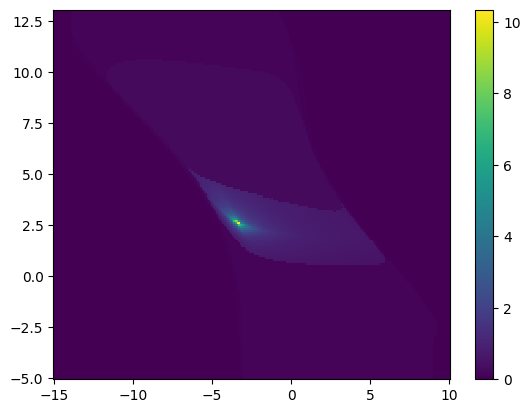

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [108]:
i = np.where(par2res.round(2) == -8.8)[0][0]
plt.pcolormesh(par1res,par3res,pyloric[:,i,:])
plt.colorbar()
plt.show()
print(pyloric[:,i,:])

In [133]:
data = pyloricavg_binning_3D(pyloric,avgs,pt_list)

0


In [143]:
print(data[np.where(data>0)])

[2.000e+00 2.000e+01 4.000e+00 1.000e+00 1.000e+00 7.000e+00 1.900e+01
 1.200e+01 9.000e+00 4.000e+00 3.020e+02 6.620e+02 5.130e+02 1.140e+02
 2.000e+00 2.000e+00 1.600e+01 1.600e+01 1.000e+00 1.700e+01 1.120e+02
 2.600e+01 7.560e+02 2.000e+00 9.000e+01 3.000e+00 2.000e+00 5.000e+00
 1.300e+01 9.000e+00 6.000e+00 1.000e+00 1.400e+01 2.500e+01 1.900e+01
 4.000e+00 3.120e+02 4.000e+00 1.700e+01 2.000e+01 3.000e+00 1.100e+01
 9.000e+00 6.000e+00 1.200e+01 9.000e+00 4.000e+00 2.740e+02 1.000e+00
 1.000e+00 6.200e+01 1.190e+02 8.000e+00 8.000e+00 1.000e+01 1.400e+01
 5.000e+00 1.100e+01 1.440e+02 1.000e+01 6.300e+01 3.000e+00 7.200e+01
 1.980e+02 5.500e+01 4.700e+01 3.300e+01 1.400e+01 5.000e+00 7.000e+00
 1.900e+01 3.000e+00 1.800e+01 8.100e+01 2.300e+01 4.000e+00 1.020e+02
 2.350e+02 9.900e+01 1.050e+02 1.180e+02 1.300e+01 2.000e+00 1.000e+00
 1.000e+00 3.000e+00 5.700e+01 1.200e+01 1.900e+01 1.500e+01 1.120e+02
 2.170e+02 9.200e+01 1.760e+02 2.300e+02 1.800e+01 2.000e+00 3.000e+00
 1.500

In [144]:
#compress data into success/mixed/fail format -- 0:fail, 1:mixed, 2:success
compressed_data = np.zeros_like(data[:,:,:,0])
for i in range(len(data)):
    for j in range(len(data[0])):
        for k in range(len(data[0,0])):
            if data[i,j,k,1] > 0:
                if data[i,j,k,0] > 0:
                    compressed_data[i,j,k] = 1
                else:
                    compressed_data[i,j,k] = 2

In [146]:
print(np.where(compressed_data==1))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [9]:
colors_avgs = rainbow(np.linspace(0,1,3))
french_gray = '#BEBFC5'

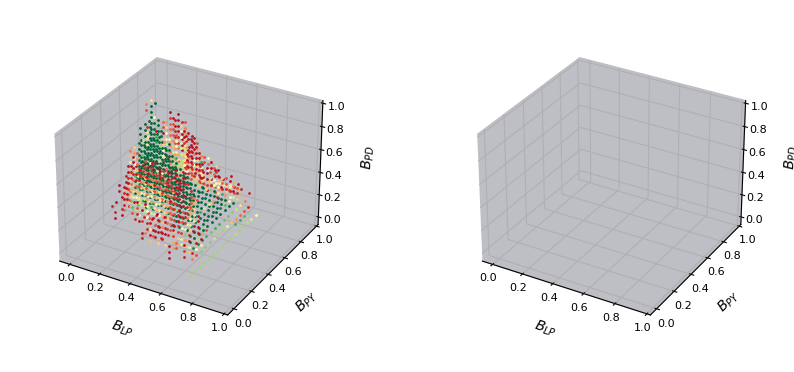

In [136]:
#first attempt
data_compressed_flattened = compressed_data.flatten()
fig = plt.figure(figsize=(10,10),facecolor = 'w')
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
fig.subplots_adjust(hspace=.05)

ax1.xaxis.set_pane_color(french_gray)
ax1.yaxis.set_pane_color(french_gray)
ax1.zaxis.set_pane_color(french_gray)
ax1.set_box_aspect(None, zoom=0.85)
ax1.grid(True)
for i in range(len(pts)):
    ax1.scatter(pts[i,0],pts[i,1],pts[i,2],color=colors[combined_slice_flattened[i].astype(int)],s=1,alpha=(combined_slice_flattened[i]>0).astype(int))
ax1.set_xlabel(r'$B_{LP}$')
ax1.set_ylabel(r'$B_{PY}$')
ax1.set_zlabel(r'$B_{PD}$')
ax1.tick_params(pad=-1)
ax1.xaxis.set_tick_params(pad=-2.5)
ax1.set_xticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax1.set_yticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax1.set_zticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)

ax2.xaxis.set_pane_color(french_gray)
ax2.yaxis.set_pane_color(french_gray)
ax2.zaxis.set_pane_color(french_gray)
ax2.set_box_aspect(None, zoom=0.85)
ax2.grid(True)
for i in range(len(pts)):
    ax2.scatter(pts[i,0],pts[i,1],pts[i,2],color=colors_avgs[data_compressed_flattened[i].astype(int)],s=1,alpha=(data_compressed_flattened[i]>0).astype(int))
ax2.set_xlabel(r'$B_{LP}$')
ax2.set_ylabel(r'$B_{PY}$')
ax2.set_zlabel(r'$B_{PD}$')
ax2.tick_params(pad=-1)
ax2.xaxis.set_tick_params(pad=-2.5)
ax2.set_xticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax2.set_yticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax2.set_zticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
plt.show()

In [147]:
#load in the data that was calculated online and make into the success/mixed/fail format
online_data_pyloric = np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/0/predictedADHPstatus_pyloric_39.dat').reshape((21,21,21))
online_data_nonpyloric = np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/0/predictedADHPstatus_pyloric_39.dat').reshape((21,21,21))
#add the rest of the slices
for i in range(1,320):
    # print(i)
    online_data_pyloric = online_data_pyloric + np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/%s/predictedADHPstatus_pyloric_39.dat'%i).reshape((21,21,21))
    online_data_nonpyloric = online_data_nonpyloric + np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/%s/predictedADHPstatus_nonpyloric_39.dat'%i).reshape((21,21,21))

In [ ]:
print(np.where(online_data_pyloric>1))

(array([ 0,  0,  0, ..., 16, 16, 16]), array([16, 16, 16, ..., 13, 14, 15]), array([ 9, 10, 11, ...,  2,  2,  2]))


In [152]:
online_data_predictions = np.zeros_like(online_data_pyloric)
for i in range(len(online_data_nonpyloric)):
    for j in range(len(online_data_nonpyloric[0])):
        for k in range(len(online_data_nonpyloric[0,0])):
            if online_data_pyloric[i,j,k] > 0:
                online_data_predictions[i,j,k] += 2
                if online_data_nonpyloric[i,j,k] > 0:
                    online_data_predictions[i,j,k] -= 1
online_data_predictions_flat = online_data_predictions.flatten()
print(np.where(online_data_predictions == 1))

(array([ 0,  0,  0, ..., 16, 16, 16]), array([16, 16, 16, ..., 13, 14, 15]), array([ 9, 10, 11, ...,  2,  2,  2]))


In [165]:
mixed_idxs = np.where(online_data_predictions==1)
pt_list = np.round(pt_list,2)
for i in range(len(mixed_idxs[0])):
    print(pt_list[mixed_idxs[0][i]],pt_list[mixed_idxs[1][i]],pt_list[mixed_idxs[2][i]])

0.0 0.8 0.45
0.0 0.8 0.5
0.0 0.8 0.55
0.0 0.8 0.6
0.0 0.8 0.65
0.0 0.8 0.7
0.0 0.8 0.75
0.0 0.8 0.8
0.0 0.8 0.85
0.0 0.8 0.9
0.0 0.85 0.45
0.0 0.85 0.5
0.0 0.85 0.55
0.0 0.85 0.6
0.0 0.85 0.65
0.0 0.85 0.7
0.0 0.85 0.75
0.0 0.85 0.8
0.0 0.85 0.85
0.0 0.85 0.9
0.05 0.55 0.35
0.05 0.55 0.4
0.05 0.6 0.35
0.05 0.6 0.4
0.05 0.6 0.45
0.05 0.6 0.5
0.05 0.6 0.55
0.05 0.6 0.6
0.05 0.6 0.65
0.05 0.6 0.7
0.05 0.6 0.75
0.05 0.6 0.8
0.05 0.6 0.85
0.05 0.65 0.35
0.05 0.65 0.4
0.05 0.65 0.45
0.05 0.65 0.5
0.05 0.65 0.55
0.05 0.65 0.6
0.05 0.65 0.65
0.05 0.65 0.7
0.05 0.65 0.75
0.05 0.65 0.8
0.05 0.65 0.85
0.05 0.7 0.35
0.05 0.7 0.4
0.05 0.7 0.45
0.05 0.7 0.5
0.05 0.7 0.55
0.05 0.7 0.6
0.05 0.7 0.65
0.05 0.7 0.7
0.05 0.7 0.75
0.05 0.7 0.8
0.05 0.7 0.85
0.05 0.7 0.9
0.05 0.75 0.4
0.05 0.75 0.45
0.05 0.75 0.5
0.05 0.75 0.55
0.05 0.75 0.6
0.05 0.75 0.65
0.05 0.75 0.7
0.05 0.75 0.75
0.05 0.75 0.8
0.05 0.75 0.85
0.05 0.75 0.9
0.05 0.8 0.4
0.05 0.8 0.45
0.05 0.8 0.5
0.05 0.8 0.55
0.05 0.8 0.6
0.05 0.8 0.65


In [153]:
colors_smf = [colors[0],colors[14],colors[-1]]

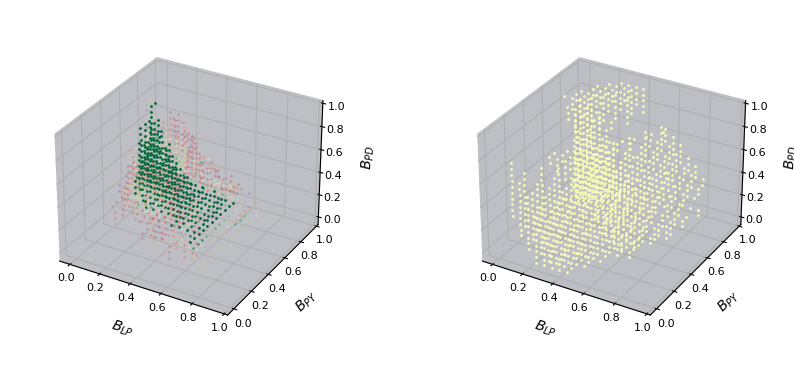

In [154]:
#trying again with the online prediction mechanism
# data_compressed_flattened = compressed_data.flatten()
fig = plt.figure(figsize=(10,10),facecolor = 'w')
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
fig.subplots_adjust(hspace=.02)

ax1.xaxis.set_pane_color(french_gray)
ax1.yaxis.set_pane_color(french_gray)
ax1.zaxis.set_pane_color(french_gray)
ax1.set_box_aspect(None, zoom=0.85)
ax1.grid(True)
for i in range(len(pts)):
    ax1.scatter(pts[i,0],pts[i,1],pts[i,2],color=colors[combined_slice_flattened[i].astype(int)],s=1/(28-combined_slice_flattened[i]),alpha=(combined_slice_flattened[i]>0).astype(int))
ax1.set_xlabel(r'$B_{LP}$')
ax1.set_ylabel(r'$B_{PY}$')
ax1.set_zlabel(r'$B_{PD}$')
ax1.tick_params(pad=-1)
ax1.xaxis.set_tick_params(pad=-2.5)
ax1.set_xticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax1.set_yticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax1.set_zticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)

ax2.xaxis.set_pane_color(french_gray)
ax2.yaxis.set_pane_color(french_gray)
ax2.zaxis.set_pane_color(french_gray)
ax2.set_box_aspect(None, zoom=0.85)
ax2.grid(True)
for i in range(len(pts)):
    ax2.scatter(pts[i,0],pts[i,1],pts[i,2],color=colors_smf[online_data_predictions_flat[i].astype(int)],s=1,alpha=(online_data_predictions_flat[i]>0).astype(int))
ax2.set_xlabel(r'$B_{LP}$')
ax2.set_ylabel(r'$B_{PY}$')
ax2.set_zlabel(r'$B_{PD}$')
ax2.tick_params(pad=-1)
ax2.xaxis.set_tick_params(pad=-2.5)
ax2.set_xticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax2.set_yticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
ax2.set_zticks(np.arange(0,1.01,.2).round(2),np.arange(0,1.01,.2).round(2),fontsize=8)
plt.show()

In [172]:
#is there even one micro-slice where full pyloricness remains possible? This would be more evidence for the time
#restriction being at fault
count = 0
for i in range(0,320):
    # print(i)
    online_data_pyloric = np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/%s/predictedADHPstatus_pyloric_39.dat'%i).reshape((21,21,21))
    online_data_nonpyloric = np.loadtxt('./Test3DHPonPyloricSolutions/predictedHPperformanceslice/%s/predictedADHPstatus_nonpyloric_39.dat'%i).reshape((21,21,21))
    pyloricidxs = np.where(online_data_pyloric>0)
    nonpyl_wherepyl = online_data_nonpyloric[pyloricidxs]
    if len(np.where(nonpyl_wherepyl==0)[0])>0:
        count += 1
print(count)

101


After all that computing, and redoing with a longer pyloric test duration, the two paradigms still don't correspond. Wait holy shit i didn't actually increase the time allotted because i changed only one of the required variables. The new paradigm predicts that the averages should still be inseparable and that mixed performance should occur in places it doesn't. It also predicts mixed performance in places no pyloric endpoints should exist. The general shape in the middle is still very similar to the raw calculations from before, so it is likely not that I have transformed the dimensions incorrectly. 

    
    For example, endpoint [-2.06198 -6.98473 1.61687] for [0.15 0.5 0.4], gives [0.150339 0.497243 0.398943] (good)

    and endpoint [-1.09699 -6.20039 0.200249] for [0.0339939 0.771726 0.427377], gives [0.0301813 0.78085 0.431289] (pretty good)
    

They correspond to the HP-specified values, so there is something else wrong going on. What is wrong with the avgpyloriccombo program? Just the rounding?

The only possibility is that HP is speeding up or reshaping oscillations that would otherwise be too slow to be considered pyloric, possibly due to the technicalities of the fitness function like the time limit and excluding multiperiodicity. To test, run the HPs then test pyloricness with HP off? Not supported

The function also had a bug where the end of one slice didn't perfectly lead to the other. Only one row into the last par1 slice. Really, what it should have been was exact same values for cutoffs and starts in the res files
But more data would make this problem worse, not better

There seems to be mad multiperiodicity errors in this volume... I wonder if they correspond to true violations...if so there must be a region of them

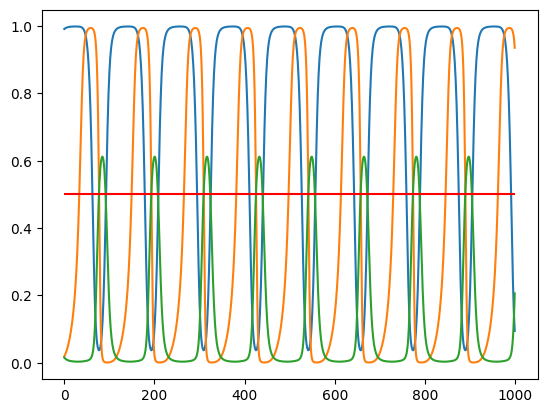

In [100]:
traj = np.loadtxt('./Specifically Evolved HP mechanisms/Every Circuit/39/pylorictrajectory_copy.ns').reshape(-1,3)
for i in range(3):
    plt.plot(traj[-1000:,i])
plt.hlines(.5,0,1000,'r')
plt.show()